# Pytorchを使用したFinetuningによる八重鑑別
参考: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import copy
from tqdm import tqdm

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Datasetの作成
Data augmentation
* 縦横を9割 ~ 10割でランダムに繰り抜く. (ストックが端のほうに写っていることがあるので下手に割合を増やせない. )
* 最終的にImageNet画像の平均値でNormalizeする. 
* validation dataでは, 切り取りや回転を行わない. 

In [3]:
!pwd

/Users/machidakentarou/GitHub/stock_2022


In [2]:
dataset_path = './data/splitted_data'

input_size = 224
batch_size = 8

# Data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size, scale=(0.9, 1), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
         transforms.Resize(input_size),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# train, val datasetの作成
image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_path, x), data_transforms[x]) for x in ['train', 'val']}

# dataloaderの作成
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# デバイスの確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## modelの準備

In [3]:
# Resnetの場合
# resnetそのものも学習するときはFalse
# 追加した層だけを学習するならTrue
feature_extracting = False
num_classes = 2

model = models.resnet18(pretrained=True, progress=True)

# modelの凍結処理
if feature_extracting:
    for param in model.parameters():
        param.requires_grad = False

# resnet18は, (Bacth, 512)のtensor を出力するのでLinearをくっつけて2出力に
num_out_features = model.fc.in_features
model.fc = nn.Linear(num_out_features, num_classes)

print(model)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
# Efficient Netの場合

feature_extracting = False
num_classes = 2

model = models.efficientnet_b3(pretrained=True, progress=True)

# modelの凍結処理
if feature_extracting:
    for param in model.parameters():
        param.requires_grad = False

# 最後の分類ブロックだけ書き換え
# 本来は1536 -> 1000 の分類を行う.
# (ソースコードを見て書き換え)
model.classifier[1]=nn.Linear(1536, num_classes)

print(model)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

## Optimizer
更新するべき重みのみを更新するOptimizerを作成する. デフォルトの設定では, modelに追加された重みは".requires_grad=True"となっている． ".requires_grad"=True の重みのみをoptimizerに渡す. 

* ResNetを特徴抽出で使用する場合, 最終層のみoptimizerに渡す. 
* Finetuningを使用する場合, 全ての重みをoptimizerに渡す. 

In [5]:
# modelをGPUに送る
model = model.to(device)

params_to_update = model.parameters()
print("Params to learn: ")

if feature_extracting:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)

else:
    for name, param in model.named_parameters():
        if param.requires_grad==True:
            print("\t", name)

optimizer = optim.SGD(params_to_update, lr = 0.001, momentum=0.9)

Params to learn: 
	 features.0.0.weight
	 features.0.1.weight
	 features.0.1.bias
	 features.1.0.block.0.0.weight
	 features.1.0.block.0.1.weight
	 features.1.0.block.0.1.bias
	 features.1.0.block.1.fc1.weight
	 features.1.0.block.1.fc1.bias
	 features.1.0.block.1.fc2.weight
	 features.1.0.block.1.fc2.bias
	 features.1.0.block.2.0.weight
	 features.1.0.block.2.1.weight
	 features.1.0.block.2.1.bias
	 features.1.1.block.0.0.weight
	 features.1.1.block.0.1.weight
	 features.1.1.block.0.1.bias
	 features.1.1.block.1.fc1.weight
	 features.1.1.block.1.fc1.bias
	 features.1.1.block.1.fc2.weight
	 features.1.1.block.1.fc2.bias
	 features.1.1.block.2.0.weight
	 features.1.1.block.2.1.weight
	 features.1.1.block.2.1.bias
	 features.2.0.block.0.0.weight
	 features.2.0.block.0.1.weight
	 features.2.0.block.0.1.bias
	 features.2.0.block.1.0.weight
	 features.2.0.block.1.1.weight
	 features.2.0.block.1.1.bias
	 features.2.0.block.2.fc1.weight
	 features.2.0.block.2.fc1.bias
	 features.2.0.block.2.f

## Training function

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    """
    output:
    (best_model, list of accuracy per epoch)
    """
    since = time.time()

    val_acc_history = []

    # deepcopy はオブジェクトをメモリの全く別の場所にコピーする
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'{epoch}/{num_epochs-1}')
        print('-'*10)

        # epochごとの学習ステップと検証ステップの処理
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to validation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                # trainモードの時だけ, 勾配をためるようにしとく
                with torch.set_grad_enabled(phase == 'train'):
                    logits = model(inputs)
                    loss = criterion(logits, labels)
                    _, preds = torch.max(logits, 1)

                    # backwardとoptimizeをtrainの時のみ行う
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # stepでのlossとacc
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # モデルのdeep copy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

## Training and Validation Step

In [7]:
num_epochs = 10

criterion = nn.CrossEntropyLoss()

# Train and evaluate
best_model, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

0/9
----------


100%|██████████| 265/265 [08:40<00:00,  1.96s/it]


train Loss: 0.6671 Acc: 0.5972


100%|██████████| 76/76 [01:15<00:00,  1.01it/s]


val Loss: 0.7564 Acc: 0.6407

1/9
----------


100%|██████████| 265/265 [08:38<00:00,  1.96s/it]


train Loss: 0.5483 Acc: 0.7314


100%|██████████| 76/76 [01:18<00:00,  1.03s/it]


val Loss: 0.7106 Acc: 0.7699

2/9
----------


100%|██████████| 265/265 [08:51<00:00,  2.01s/it]


train Loss: 0.4320 Acc: 0.8052


100%|██████████| 76/76 [01:18<00:00,  1.03s/it]


val Loss: 0.4638 Acc: 0.7897

3/9
----------


100%|██████████| 265/265 [08:46<00:00,  1.99s/it]


train Loss: 0.3752 Acc: 0.8378


100%|██████████| 76/76 [01:14<00:00,  1.02it/s]


val Loss: 0.6326 Acc: 0.8046

4/9
----------


100%|██████████| 265/265 [08:22<00:00,  1.90s/it]


train Loss: 0.3178 Acc: 0.8662


100%|██████████| 76/76 [01:14<00:00,  1.02it/s]


val Loss: 2.2158 Acc: 0.8013

5/9
----------


100%|██████████| 265/265 [08:24<00:00,  1.90s/it]


train Loss: 0.2658 Acc: 0.8941


100%|██████████| 76/76 [01:14<00:00,  1.02it/s]


val Loss: 0.3618 Acc: 0.8394

6/9
----------


100%|██████████| 265/265 [12:48<00:00,  2.90s/it]


train Loss: 0.2298 Acc: 0.9125


100%|██████████| 76/76 [01:55<00:00,  1.52s/it]


val Loss: 0.4516 Acc: 0.8146

7/9
----------


100%|██████████| 265/265 [1:27:01<00:00, 19.70s/it]     


train Loss: 0.1863 Acc: 0.9277


100%|██████████| 76/76 [01:47<00:00,  1.41s/it]


val Loss: 0.3228 Acc: 0.8775

8/9
----------


100%|██████████| 265/265 [08:18<00:00,  1.88s/it]


train Loss: 0.1680 Acc: 0.9333


100%|██████████| 76/76 [01:14<00:00,  1.01it/s]


val Loss: 0.3417 Acc: 0.8576

9/9
----------


100%|██████████| 265/265 [08:17<00:00,  1.88s/it]


train Loss: 0.1471 Acc: 0.9428


100%|██████████| 76/76 [01:13<00:00,  1.03it/s]

val Loss: 0.3684 Acc: 0.8328

Training complete in 181m 57s
Best val Acc: 0.877483


No handles with labels found to put in legend.


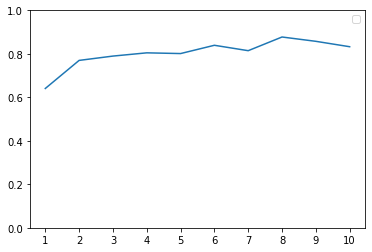

In [8]:
import matplotlib.pyplot as plot
import numpy as np

acc_history = [h.cpu().numpy() for h in hist]
plot.plot(range(1, num_epochs+1), acc_history)
plot.ylim((0,1.))
plot.xticks(np.arange(1, num_epochs+1, 1.0))
plot.legend()
plot.show()

In [9]:
import os
save_dir = './trained_models'

model_name = "Efficientnet_b3.pth"
model_path = os.path.join(save_dir, model_name)

torch.save(model, model_path)